In [10]:
from google.colab import files
from tqdm import tqdm
# uploaded = files.upload()
import gcsfs
import os
import pandas as pd
import glob
import dask.dataframe as dd
import re
import gc
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from dask.diagnostics import ProgressBar
import numpy as np
import networkx as nx
import itertools
import calendar
import random
import pickle
from datetime import datetime
from datetime import timedelta

In [11]:
# adding a progress bar for every code run using dask
ProgressBar().register()

In [12]:
# Using dask to create a lazy df
df_feb_apr_19 = dd.read_parquet("/content/feb_apr_2019_export/*.parquet")
df_feb_apr_20 = dd.read_parquet("/content/feb_apr_2020_export/*.parquet")

In [6]:
df_feb_apr_19.head()
df_feb_apr_20.head()

[########################################] | 100% Completed | 505.40 ms
[########################################] | 100% Completed | 604.89 ms
[########################################] | 100% Completed | 416.49 ms
[########################################] | 100% Completed | 404.29 ms


,id,type,created_at,actor,repo,payload
0,12088780983,IssuesEvent,2020-04-18 20:25:51,Dbzman,AOEpeople/gitlab-crucible-bridge,"{""action"":""closed"",""issue"":{""url"":""https://api..."
1,11502079848,IssuesEvent,2020-02-12 18:24:23,MikeRalphson,APIs-guru/openapi-directory,"{""action"":""closed"",""issue"":{""url"":""https://api..."
2,11692935302,IssuesEvent,2020-03-05 23:49:06,hol353,APSIMInitiative/ApsimX,"{""action"":""closed"",""issue"":{""url"":""https://api..."
3,11997965293,IssuesEvent,2020-04-08 19:32:53,IvoPaunov,AdExNetwork/adex-platform,"{""action"":""closed"",""issue"":{""url"":""https://api..."
4,11779449716,IssuesEvent,2020-03-16 18:02:47,Alex-302,AdguardTeam/AdguardFilters,"{""action"":""closed"",""issue"":{""url"":""https://api..."


In [13]:
gc.collect()

90

In [14]:
# selecting only required columns
df_network_19 = df_feb_apr_19[['created_at', 'repo', 'actor']]
df_network_20 = df_feb_apr_20[['created_at', 'repo', 'actor']]

In [15]:
# changin the created_at column to date time data type
df_network_19['created_at'] = dd.to_datetime(df_network_19['created_at'])
df_network_20['created_at'] = dd.to_datetime(df_network_20['created_at'])

# adding a week column with the start date of each week
df_network_19['week'] = df_network_19['created_at'].dt.to_period('W').dt.start_time
df_network_20['week'] = df_network_20['created_at'].dt.to_period('W').dt.start_time

In [16]:
def weekly_graph_build(df, save_dir):
  # making a dir if does not exist
  os.makedirs(save_dir, exist_ok=True)

  # getting a set of already completed graph files
  existing_files = set(os.listdir(save_dir))

  # a sorted list of all unique weeks
  unique_weeks = df['week'].drop_duplicates().compute().sort_values().tolist()

  # looping through each week to build graphs
  for week in tqdm(unique_weeks, desc = "Building weekly graphs"):
    # filename to save and the path to save
    filename = f"week_{week.date()}.gpickle"
    full_path = os.path.join(save_dir, filename)

    # skipping if the graph file is already present
    if filename in existing_files:
      print(f"already built the graph for {week} week")
      continue

    print(f"processing week: {week}")

    # computing the data of the week
    df_week = df[df['week'] == week].compute().copy()
    # grouping by repo and getting a list of devs on each repo
    week_repo_groups = df_week.groupby('repo')['actor'].apply(list).reset_index()

    G = nx.Graph()
    repos_skipped = 0

    # adding edges between devs who worked on the same repo
    for devs in week_repo_groups['actor']:
      # adding a cap to build the graph (to be in limit of computing power)
      if len(devs) > 1 and len(devs) < 20000:
        G.add_edges_from(itertools.combinations(set(devs), 2))
      elif len(devs) > 20000:
        repos_skipped += 1

    # saving the graph
    with open(full_path, 'wb') as file:
      pickle.dump(G, file)

    del df_week, week_repo_groups, G
    gc.collect()


In [11]:
# building weekly graphs for 2020 data
weekly_graph_build(df_network_20, save_dir='/content/graphs/2020')

[########################################] | 100% Completed | 90.69 s
[########################################] | 100% Completed | 90.78 s


Building weekly graphs:   0%|          | 0/14 [00:00<?, ?it/s]

processing week: 2020-01-27 00:00:00
[########################################] | 100% Completed | 92.38 s
[########################################] | 100% Completed | 92.32 s


Building weekly graphs:   7%|▋         | 1/14 [01:45<22:49, 105.38s/it]

processing week: 2020-02-03 00:00:00
[########################################] | 100% Completed | 90.48 s
[########################################] | 100% Completed | 90.54 s


Building weekly graphs:  14%|█▍        | 2/14 [05:16<33:29, 167.49s/it]

processing week: 2020-02-10 00:00:00
[########################################] | 100% Completed | 95.13 s
[########################################] | 100% Completed | 95.17 s


Building weekly graphs:  21%|██▏       | 3/14 [08:57<35:09, 191.81s/it]

processing week: 2020-02-17 00:00:00
[########################################] | 100% Completed | 91.59 s
[########################################] | 100% Completed | 91.65 s


Building weekly graphs:  29%|██▊       | 4/14 [13:00<35:23, 212.31s/it]

processing week: 2020-02-24 00:00:00
[########################################] | 100% Completed | 96.06 s
[########################################] | 100% Completed | 96.10 s


Building weekly graphs:  36%|███▌      | 5/14 [17:25<34:41, 231.24s/it]

processing week: 2020-03-02 00:00:00
[########################################] | 100% Completed | 91.44 s
[########################################] | 100% Completed | 91.41 s


Building weekly graphs:  43%|████▎     | 6/14 [21:56<32:37, 244.71s/it]

processing week: 2020-03-09 00:00:00
[########################################] | 100% Completed | 90.90 s
[########################################] | 100% Completed | 90.94 s


Building weekly graphs:  50%|█████     | 7/14 [26:44<30:11, 258.85s/it]

processing week: 2020-03-16 00:00:00
[########################################] | 100% Completed | 95.37 s
[########################################] | 100% Completed | 95.34 s


Building weekly graphs:  57%|█████▋    | 8/14 [31:46<27:15, 272.63s/it]

processing week: 2020-03-23 00:00:00
[########################################] | 100% Completed | 102.53 s
[########################################] | 100% Completed | 102.53 s


Building weekly graphs:  64%|██████▍   | 9/14 [36:44<23:22, 280.55s/it]

processing week: 2020-03-30 00:00:00
[########################################] | 100% Completed | 107.03 s
[########################################] | 100% Completed | 107.07 s


Building weekly graphs:  71%|███████▏  | 10/14 [42:09<19:36, 294.21s/it]

processing week: 2020-04-06 00:00:00
[########################################] | 100% Completed | 105.36 s
[########################################] | 100% Completed | 105.30 s


Building weekly graphs:  79%|███████▊  | 11/14 [47:21<14:59, 299.76s/it]

processing week: 2020-04-13 00:00:00
[########################################] | 100% Completed | 87.19 s
[########################################] | 100% Completed | 87.23 s


Building weekly graphs:  86%|████████▌ | 12/14 [53:06<10:26, 313.38s/it]

processing week: 2020-04-20 00:00:00
[########################################] | 100% Completed | 88.03 s
[########################################] | 100% Completed | 88.01 s


Building weekly graphs:  93%|█████████▎| 13/14 [57:54<05:05, 305.87s/it]

processing week: 2020-04-27 00:00:00
[########################################] | 100% Completed | 94.84 s
[########################################] | 100% Completed | 94.85 s


Building weekly graphs: 100%|██████████| 14/14 [1:00:58<00:00, 261.31s/it]


In [12]:
# building weekly graphs for 2019 data
weekly_graph_build(df_network_19, save_dir='/content/graphs/2019')

[########################################] | 100% Completed | 42.00 s
[########################################] | 100% Completed | 41.99 s


Building weekly graphs:   0%|          | 0/14 [00:00<?, ?it/s]

processing week: 2019-01-28 00:00:00
[########################################] | 100% Completed | 47.38 s
[########################################] | 100% Completed | 47.34 s


Building weekly graphs:   7%|▋         | 1/14 [01:08<14:55, 68.87s/it]

processing week: 2019-02-04 00:00:00
[########################################] | 100% Completed | 44.81 s
[########################################] | 100% Completed | 44.89 s


Building weekly graphs:  14%|█▍        | 2/14 [03:47<24:20, 121.73s/it]

processing week: 2019-02-11 00:00:00
[########################################] | 100% Completed | 46.80 s
[########################################] | 100% Completed | 46.88 s


Building weekly graphs:  21%|██▏       | 3/14 [07:58<33:05, 180.54s/it]

processing week: 2019-02-18 00:00:00
[########################################] | 100% Completed | 50.66 s
[########################################] | 100% Completed | 50.74 s


Building weekly graphs:  29%|██▊       | 4/14 [13:52<41:30, 249.04s/it]

processing week: 2019-02-25 00:00:00
[########################################] | 100% Completed | 48.84 s
[########################################] | 100% Completed | 48.82 s


Building weekly graphs:  36%|███▌      | 5/14 [20:49<46:26, 309.62s/it]

processing week: 2019-03-04 00:00:00
[########################################] | 100% Completed | 50.63 s
[########################################] | 100% Completed | 50.71 s


Building weekly graphs:  43%|████▎     | 6/14 [29:04<49:41, 372.70s/it]

processing week: 2019-03-11 00:00:00
[########################################] | 100% Completed | 40.88 s
[########################################] | 100% Completed | 40.95 s


Building weekly graphs:  50%|█████     | 7/14 [33:02<38:20, 328.66s/it]

processing week: 2019-03-18 00:00:00
[########################################] | 100% Completed | 45.31 s
[########################################] | 100% Completed | 45.39 s


Building weekly graphs:  57%|█████▋    | 8/14 [37:20<30:36, 306.07s/it]

processing week: 2019-03-25 00:00:00
[########################################] | 100% Completed | 47.28 s
[########################################] | 100% Completed | 47.32 s


Building weekly graphs:  64%|██████▍   | 9/14 [42:03<24:55, 299.02s/it]

processing week: 2019-04-01 00:00:00
[########################################] | 100% Completed | 42.52 s
[########################################] | 100% Completed | 42.51 s


Building weekly graphs:  71%|███████▏  | 10/14 [46:32<19:19, 289.87s/it]

processing week: 2019-04-08 00:00:00
[########################################] | 100% Completed | 41.10 s
[########################################] | 100% Completed | 41.09 s


Building weekly graphs:  79%|███████▊  | 11/14 [52:51<15:51, 317.03s/it]

processing week: 2019-04-15 00:00:00
[########################################] | 100% Completed | 45.12 s
[########################################] | 100% Completed | 45.19 s


Building weekly graphs:  86%|████████▌ | 12/14 [59:30<11:24, 342.08s/it]

processing week: 2019-04-22 00:00:00
[########################################] | 100% Completed | 52.63 s
[########################################] | 100% Completed | 52.71 s


Building weekly graphs:  93%|█████████▎| 13/14 [1:14:04<08:22, 502.99s/it]

processing week: 2019-04-29 00:00:00
[########################################] | 100% Completed | 39.49 s
[########################################] | 100% Completed | 39.47 s


Building weekly graphs: 100%|██████████| 14/14 [1:15:21<00:00, 322.94s/it]


In [13]:
# checking the repo with more devs working on it to find out a meaningful cap which includes most repos
# computing the data for 2019 data
df_all_2019 = df_network_19.compute()

# grouping by week and repo to count unique devs per repo each week
weekly_repo_dev_counts = (
    df_all_2019.groupby(['week', 'repo'])['actor']
    .nunique()
    .reset_index()
    .rename(columns={'actor': 'num_devs'})
)

# getting top 3 repos each week
top_repos_per_week = (
    weekly_repo_dev_counts
    .sort_values(['week', 'num_devs'], ascending=[True, False])
    .groupby('week')
    .head(3)
    .reset_index(drop=True)
)

top_repos_per_week

[########################################] | 100% Completed | 45.98 s
[########################################] | 100% Completed | 45.96 s


,week,repo,num_devs
0,2019-01-28,tyroprogrammer/learn-react-app,1571
1,2019-01-28,shengxinjing/programmer-job-blacklist,1059
2,2019-01-28,RustPython/RustPython,1003
3,2019-02-04,kleampa/not-paid,4159
4,2019-02-04,pomber/github-history,2760
5,2019-02-04,toddmotto/public-apis,2729
6,2019-02-11,pomber/git-history,3672
7,2019-02-11,imthenachoman/How-To-Secure-A-Linux-Server,3521
8,2019-02-11,uber/ludwig,2776
9,2019-02-18,Micropoor/Micro8,8878


In [17]:
gc.collect()

91

In [18]:
def calc_network_metrics(graph_dir, label = None, sample_size = None):
  # initiating a list to save metrics
  metrics = []

  # getting a list of graphs sorted by week
  files = sorted(os.listdir(graph_dir))

  # looping to calculate graph metrics
  for file in tqdm(files, desc = "Calculating weekly metrics"):
    if not file.endswith('.gpickle'):
      continue

    # extracting week from the filename
    week_str = file.replace("week_", "").replace(".gpickle", "")
    week_date = datetime.strptime(week_str, '%Y-%m-%d').date()

    # loading the file
    filepath = os.path.join(graph_dir, file)

    with open(filepath, 'rb') as file:
      G = pickle.load(file)

    # skipping empty graphs
    if len(G) == 0:
      continue

    # calculating metrics
    degrees = dict(G.degree())
    avg_degree = sum(degrees.values()) / len(degrees)

    # largest connected component
    largest_cc = max(nx.connected_components(G), key=len)
    G_lcc = G.subgraph(largest_cc).copy()
    largest_cc_size = len(G_lcc)

    if len(G_lcc) > sample_size:
      sample_nodes = random.sample(list(G_lcc.nodes()), sample_size)
    else:
      sample_nodes = list(G_lcc.nodes())

    sample_subgraph = G_lcc.subgraph(sample_nodes).copy()

    clustering = nx.average_clustering(sample_subgraph)

    # ego_sample_nodes = random.sample(list(G_lcc.nodes()), min(100, len(G_lcc)))

    # ego_betweenness = []

    # for node in ego_sample_nodes:
    #   egonet = nx.ego_graph(G_lcc, node)
    #   ego_bet = nx.betweenness_centrality(egonet, normalized = True)
    #   ego_betweenness.append(ego_bet.get(node, 0))

    # avg_ego_betweenness = sum(ego_betweenness) / len(ego_betweenness)

    density = nx.density(G)
    num_components = nx.number_connected_components(G)

    metrics.append({
            'week': week_date,
            'num_nodes': G.number_of_nodes(),
            'num_edges': G.number_of_edges(),
            'density': density,
            'average_degree': avg_degree,
            'clustering_coefficient': clustering,
            # 'avg_egobetweeness': avg_ego_betweenness,
            # 'avg_k_core_num': avg_k_core,
            'number_of_components': num_components,
            'largest_component_size': largest_cc_size,
            'label' : label
        })

    del G, G_lcc, degrees, sample_nodes, clustering, largest_cc, sample_subgraph
    gc.collect()

  df_metrics = pd.DataFrame(metrics).sort_values(by='week')

  return df_metrics

In [19]:
# calculating 2019 graphs metrics
metrics_2019 = calc_network_metrics(graph_dir = '/content/graphs/2019', label = '2019', sample_size = 1000)

Calculating weekly metrics: 100%|██████████| 14/14 [3:21:38<00:00, 864.16s/it] 


In [20]:
# calculating 2020 graphs metrics
metrics_2020 = calc_network_metrics(graph_dir = '/content/graphs/2020', label = '2020', sample_size = 1000)

Calculating weekly metrics: 100%|██████████| 14/14 [1:44:32<00:00, 448.02s/it]


In [21]:
# combining the 2019 and 2020 metrics and then sorting by week
combined_metrics = pd.concat([metrics_2019, metrics_2020], ignore_index=True)
combined_metrics = combined_metrics.sort_values(by = 'week').reset_index(drop = True)

In [22]:
combined_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   week                    28 non-null     object 
 1   num_nodes               28 non-null     int64  
 2   num_edges               28 non-null     int64  
 3   density                 28 non-null     float64
 4   average_degree          28 non-null     float64
 5   clustering_coefficient  28 non-null     float64
 6   number_of_components    28 non-null     int64  
 7   largest_component_size  28 non-null     int64  
 8   label                   28 non-null     object 
dtypes: float64(3), int64(4), object(2)
memory usage: 2.1+ KB


In [23]:
# checking the metrics and the pre and post covid network trends based on the metrics
combined_metrics.head()

,week,num_nodes,num_edges,density,average_degree,clustering_coefficient,number_of_components,largest_component_size,label
0,2019-01-28,211581,8454242,0.000378,79.914945,0.095978,18964,156765,2019
1,2019-02-04,480399,55696647,0.000483,231.876615,0.078738,27521,399571,2019
2,2019-02-11,603490,96234031,0.000528,318.925023,0.104710,29187,517258,2019
3,2019-02-18,637303,157593146,0.000776,494.562699,0.130223,30273,548290,2019
4,2019-02-25,654151,177131433,0.000828,541.561300,0.106700,31398,561772,2019


In [24]:
# storing the metrics
combined_metrics.to_csv('network_metrics.csv', index = False)

In [50]:
# loading the metrics saved in csv to a df
combined_metrics = pd.read_csv('/content/network_metrics.csv', parse_dates=['week'])
combined_metrics['label'] = combined_metrics['label'].astype(str)

In [51]:
combined_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   week                    28 non-null     datetime64[ns]
 1   num_nodes               28 non-null     int64         
 2   num_edges               28 non-null     int64         
 3   density                 28 non-null     float64       
 4   average_degree          28 non-null     float64       
 5   clustering_coefficient  28 non-null     float64       
 6   number_of_components    28 non-null     int64         
 7   largest_component_size  28 non-null     int64         
 8   label                   28 non-null     object        
dtypes: datetime64[ns](1), float64(3), int64(4), object(1)
memory usage: 2.1+ KB


In [52]:
# function  to generate week labels from date time
def week_label(date):
  month = calendar.month_abbr[date.month]
  week_number = ((date.day - 1) // 7) + 1
  suffix = {1: '1st', 2: '2nd', 3: '3rd'}.get(week_number, f'{week_number}th')
  return f'{month}_{suffix}_week'

In [53]:
# making a copy of metrics df and applying week label
network_metrics = combined_metrics.copy()
network_metrics['week_label'] = network_metrics['week'].apply(week_label)

In [54]:
# order labels
weeks_ordered = network_metrics.sort_values('week')['week_label'].unique()
network_metrics['week_label'] = pd.Categorical(network_metrics['week_label'], categories=weeks_ordered, ordered=True)

In [55]:
network_metrics

,week,num_nodes,num_edges,density,average_degree,clustering_coefficient,number_of_components,largest_component_size,label,week_label
0,2019-01-28,211581,8454242,0.000378,79.914945,0.095978,18964,156765,2019,Jan_4th_week
1,2019-02-04,480399,55696647,0.000483,231.876615,0.078738,27521,399571,2019,Feb_1st_week
2,2019-02-11,603490,96234031,0.000528,318.925023,0.104710,29187,517258,2019,Feb_2nd_week
3,2019-02-18,637303,157593146,0.000776,494.562699,0.130223,30273,548290,2019,Feb_3rd_week
4,2019-02-25,654151,177131433,0.000828,541.561300,0.106700,31398,561772,2019,Feb_4th_week
5,2019-03-04,657512,212112636,0.000981,645.197764,0.110780,31236,566035,2019,Mar_1st_week
6,2019-03-11,653017,101479336,0.000476,310.801514,0.085888,32585,557154,2019,Mar_2nd_week
7,2019-03-18,660360,108048690,0.000496,327.241777,0.102680,33464,562828,2019,Mar_3rd_week
8,2019-03-25,673418,121883176,0.000538,361.983719,0.122677,34016,573438,2019,Mar_4th_week
9,2019-04-01,662521,112049999,0.000511,338.253426,0.097118,34963,559939,2019,Apr_1st_week


In [56]:
# getting extra weeks
extra_weeks = network_metrics[(network_metrics['label'] == '2020') &
                              (network_metrics['week_label'].isin(['Mar_4th_week', 'Mar_5th_week']))]

# getting the numeric columns for averaging
numeric_cols = ['num_nodes', 'num_edges', 'density', 'average_degree',
                'number_of_components', 'largest_component_size', 'clustering_coefficient']

avg_metrics = extra_weeks[numeric_cols].mean()

# getting previous weeks date
prev_week_date = extra_weeks['week'].min()

# create a new row for average values
merged_row = avg_metrics.to_dict()
merged_row['week'] = prev_week_date
merged_row['label'] = '2020'
merged_row['week_label'] = 'Mar_4th_week'

# removing the original two weeks and adding the new merged one
network_metrics = network_metrics[~((network_metrics['label'] == '2020') &
                                    (network_metrics['week_label'].isin(['Mar_4th_week', 'Mar_5th_week'])))]

# appending the new row
network_metrics = pd.concat([network_metrics, pd.DataFrame([merged_row])], ignore_index=True)

# sorting the weeks
network_metrics = network_metrics.sort_values('week').reset_index(drop=True)

In [57]:
network_metrics

,week,num_nodes,num_edges,density,average_degree,clustering_coefficient,number_of_components,largest_component_size,label,week_label
0,2019-01-28,211581.0,8454242.0,0.000378,79.914945,0.095978,18964.0,156765.0,2019,Jan_4th_week
1,2019-02-04,480399.0,55696647.0,0.000483,231.876615,0.078738,27521.0,399571.0,2019,Feb_1st_week
2,2019-02-11,603490.0,96234031.0,0.000528,318.925023,0.104710,29187.0,517258.0,2019,Feb_2nd_week
3,2019-02-18,637303.0,157593146.0,0.000776,494.562699,0.130223,30273.0,548290.0,2019,Feb_3rd_week
4,2019-02-25,654151.0,177131433.0,0.000828,541.561300,0.106700,31398.0,561772.0,2019,Feb_4th_week
5,2019-03-04,657512.0,212112636.0,0.000981,645.197764,0.110780,31236.0,566035.0,2019,Mar_1st_week
6,2019-03-11,653017.0,101479336.0,0.000476,310.801514,0.085888,32585.0,557154.0,2019,Mar_2nd_week
7,2019-03-18,660360.0,108048690.0,0.000496,327.241777,0.102680,33464.0,562828.0,2019,Mar_3rd_week
8,2019-03-25,673418.0,121883176.0,0.000538,361.983719,0.122677,34016.0,573438.0,2019,Mar_4th_week
9,2019-04-01,662521.0,112049999.0,0.000511,338.253426,0.097118,34963.0,559939.0,2019,Apr_1st_week


I can see that Jan 4th week from both 2019 and 2020 are partial weeks with 3 and 2 days in it respectively, and also april 5th week from 2019 which has 2 days, so I plan on normalizing the partial weeks.

In [58]:
# getting number of unique days per week
df_network_19['created_date'] = df_network_19['created_at'].dt.date
df_network_20['created_date'] = df_network_20['created_at'].dt.date

days_per_week_19 = df_network_19.groupby('week')['created_date'].nunique().compute()
days_per_week_20 = df_network_20.groupby('week')['created_date'].nunique().compute()

# mapping actual days into metrics
actual_days_list = []

for _, row in network_metrics.iterrows():
  week_start = row['week']
  year = row['label']

  if year == '2019':
    actual_days = days_per_week_19.get(week_start, np.nan)
  elif year == '2020':
    actual_days = days_per_week_20.get(week_start, np.nan)
  else:
    actual_days = np.nan

  actual_days_list.append(actual_days)

# creating a new column with actual number of days of each week
network_metrics['actual_days'] = actual_days_list

[########################################] | 100% Completed | 42.91 s
[########################################] | 100% Completed | 43.00 s
[########################################] | 100% Completed | 82.09 s
[########################################] | 100% Completed | 82.08 s


In [59]:
# normalizing the metrics for partial weeks only
numeric_cols = ['num_nodes', 'num_edges', 'density', 'average_degree',
                'number_of_components', 'largest_component_size', 'clustering_coefficient']

# looping to normalize the metrics for weeks with less than 7 days
for col in numeric_cols:
  network_metrics[col] = np.where(
      network_metrics['actual_days'] < 7,
      (network_metrics[col] / network_metrics['actual_days']) * 7,
      network_metrics[col]
  )

Dropping partial weeks Jan 4th weeks in both years and April 5th week in 2019 to make sure of consistency in weekly comparision, as these weeks are skewing the analysis.

In [61]:
# dropping partial weeks
network_metrics = network_metrics[~(
    ((network_metrics['label'] == '2019') & (network_metrics['week_label'].isin(['Jan_4th_week', 'Apr_5th_week']))) |
    ((network_metrics['label'] == '2020') & (network_metrics['week_label'].isin(['Jan_4th_week'])))
)]

In [62]:
network_metrics.head()

,week,num_nodes,num_edges,density,average_degree,clustering_coefficient,number_of_components,largest_component_size,label,week_label,actual_days
1,2019-02-04,480399.0,55696647.0,0.000483,231.876615,0.078738,27521.0,399571.0,2019,Feb_1st_week,7
2,2019-02-11,603490.0,96234031.0,0.000528,318.925023,0.104710,29187.0,517258.0,2019,Feb_2nd_week,7
3,2019-02-18,637303.0,157593146.0,0.000776,494.562699,0.130223,30273.0,548290.0,2019,Feb_3rd_week,7
4,2019-02-25,654151.0,177131433.0,0.000828,541.561300,0.106700,31398.0,561772.0,2019,Feb_4th_week,7
5,2019-03-04,657512.0,212112636.0,0.000981,645.197764,0.110780,31236.0,566035.0,2019,Mar_1st_week,7


In [63]:
network_metrics.to_csv('final_network_metrics.csv', index = False)

In [64]:
# loading the metrics saved in csv to a df
network_metrics = pd.read_csv('/content/final_network_metrics.csv', parse_dates=['week'])
network_metrics['label'] = network_metrics['label'].astype(str)

In [65]:
# rounding the metrics to 2 decimal places
float_cols = ['num_nodes', 'num_edges', 'average_degree',
                'number_of_components', 'largest_component_size', 'clustering_coefficient']

network_metrics[float_cols] = network_metrics[float_cols].astype(float).round(2)

In [ ]:
# pd.reset_option('display.float_format')

In [123]:
network_metrics

,week,num_nodes,num_edges,density,average_degree,clustering_coefficient,number_of_components,largest_component_size,label,week_label,actual_days
0,2019-02-04,480399.0,55696647.0,0.000483,231.88,0.08,27521.00,399571.00,2019,Feb_1st_week,7
1,2019-02-11,603490.0,96234031.0,0.000528,318.93,0.10,29187.00,517258.00,2019,Feb_2nd_week,7
2,2019-02-18,637303.0,157593146.0,0.000776,494.56,0.13,30273.00,548290.00,2019,Feb_3rd_week,7
3,2019-02-25,654151.0,177131433.0,0.000828,541.56,0.11,31398.00,561772.00,2019,Feb_4th_week,7
4,2019-03-04,657512.0,212112636.0,0.000981,645.20,0.11,31236.00,566035.00,2019,Mar_1st_week,7
5,2019-03-11,653017.0,101479336.0,0.000476,310.80,0.09,32585.00,557154.00,2019,Mar_2nd_week,7
6,2019-03-18,660360.0,108048690.0,0.000496,327.24,0.10,33464.00,562828.00,2019,Mar_3rd_week,7
7,2019-03-25,673418.0,121883176.0,0.000538,361.98,0.12,34016.00,573438.00,2019,Mar_4th_week,7
8,2019-04-01,662521.0,112049999.0,0.000511,338.25,0.10,34963.00,559939.00,2019,Apr_1st_week,7
9,2019-04-08,689125.0,168516452.0,0.000710,489.07,0.13,35431.00,586236.00,2019,Apr_2nd_week,7


In [102]:
# creating a function to plot the metrics for both 2019 and 2020 easy way
def metrics_plot(df, metric, ylabel = None, title = None, use_log = False):
  plt.figure(figsize=(14, 6))
  # looping through each year to plot its trend
  for year in ['2019', '2020']:
    data = df[df['label'] == year]
    plt.plot(data['week_label'], data[metric], marker = 'o', label = year, linewidth = 2)

  # setting a plot title
  plt.title(title or f"{ylabel} - weekly trend (2019 vs 2020)", fontsize = 14)
  plt.xlabel('week', fontsize = 12)
  plt.ylabel(ylabel, fontsize = 12)
  plt.xticks(rotation = 45)

  ax = plt.gca()
  if use_log:
    plt.yscale('log')
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
  else:
    if df[metric].max() < 1:
      ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.4f}'))
    else:
      ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))

  plt.grid(True, linestyle = '--', alpha = 0.5)
  plt.legend()
  plt.tight_layout()
  plt.show()

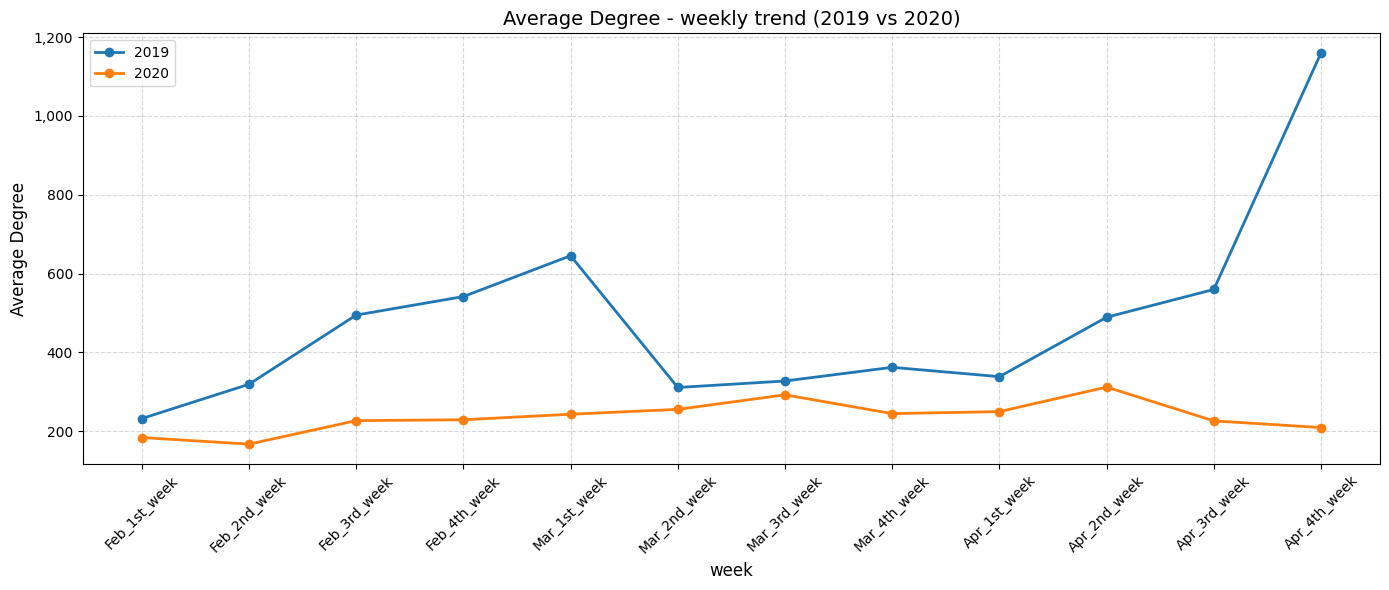

In [94]:
# plotting avg degree over time
metrics_plot(network_metrics, 'average_degree', 'Average Degree')

- The Average degree represents the average number of connections per developer, and I can see a consistently higher trend in 2019 compared to 2020, which indicated a denser and more interconnected developer network.  
- In 2019, average degree steadily increased through Febuary from around 230 and peaked in early March at around 640 which shows growing collaboration and interconnectivity, followed by a dip after it and there is a rise again with reaching an overall peak of 1160 by the end of April, showing very high interconnectivity.
- In 2020, the average degree started lower at 183 and remained stable between 165 and 315 through the overall period, this suggests more isolated or smaller scale collaborations. It reached a peak mid April with 311 and then is followed by a sharp dip to around 200 by last week of April, which reflects reduced collaboration intensity, possibly due to pandemic related disruptions.
- While both years show similar upward trends in Febuary and March, the magnitude and fluctuations of 2019 shows larger more integrated collaborations, in contrast in 2020's it is a smoother, flatter trend which reflects more fragmented interaction pattern, possibly due to COVID.

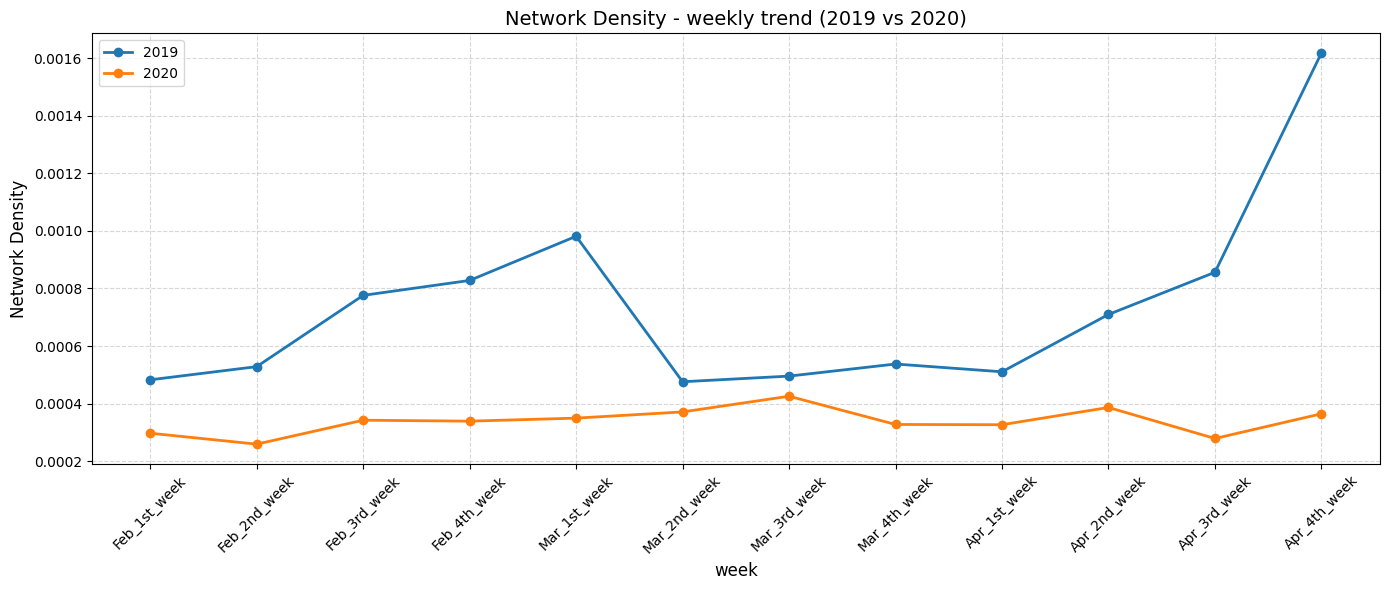

In [95]:
# plotting for density over time
metrics_plot(network_metrics, 'density', 'Network Density')

-  Network density measures how interconnected the overall developer network is, a higher density means more tightly interconnected network. And the Network density also shows similar trend as Average degree for 2019 and 2020.
- In 2019, the density showed a strong rising trend from 0.00048 in early Febuary to a peak of around 0.00098 in early March. After this peak, there was dip in mid March to around 0.00047, but then again it climbed to a peak at the end of April at 0.00103 which indicates a tightly connected collaboration structure toward the end of the period.
- In 2020, the trend was smoother and flatter starting at around 0.00029, fluctuating slightly but was under 0.00042 mid March, but then gradually declined to 0.00021 at the last week of April, indicating a looser or more fragmented collaboration pattern.
- While both years follow a general increase in Febuary and ealy March, 2019 stands out for its sharper rise and higher values, which shows larger scale, more cohesive collaborations. In 2020, the flatter trend and overall low density in comparision to 2019 shows the early impact of COVID, which lead to more distributed and isolated development efforts.

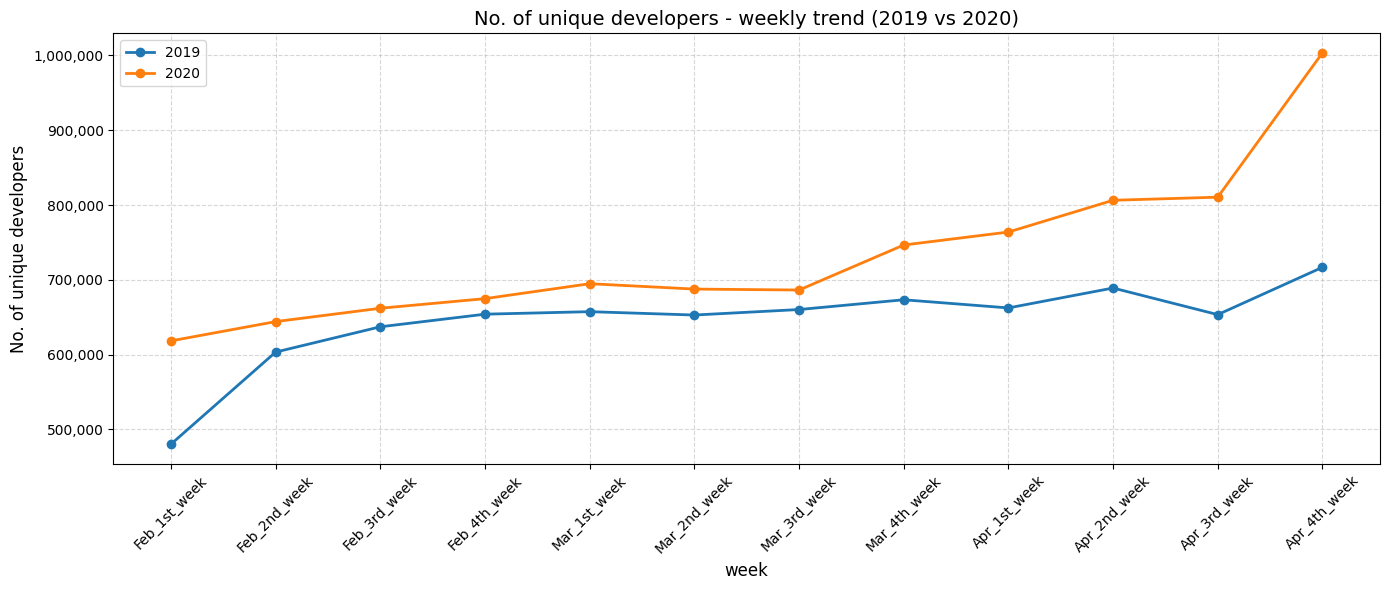

In [96]:
# plotting for no of developers
metrics_plot(network_metrics, 'num_nodes','No. of unique developers')

- The Number of nodes represent the Number of unique developers participating each week, and I can see by each week 2020 consistently remained higher than 2019 where both in 2019 and 2020 the peak was at the end of April with 705K and 1000K developers respectively.
- In 2019, developer participation shows a steady climb from 2nd week of Febuary till early March from 480K in the 1st week of Febuary and started seeing fluctuations then after with a peak at the end of April with more than 700K developers.
- In 2020, there was smoother rise from Febuary to 1st week of March with just under 700K developers, then followed a little dip till 3rd week of March from where there was a sharp rise till end of April with a peak of more than 1000K developers, which suggests an accelerated growth in developer engagement.
- While 2020 has more participating developers overall, this did not particularly say about the collaboration intensity, as seen in average degree and density. This contrast says that although more developer were active in 2020, they might have been working in smaller scale interactions compared to 2019.

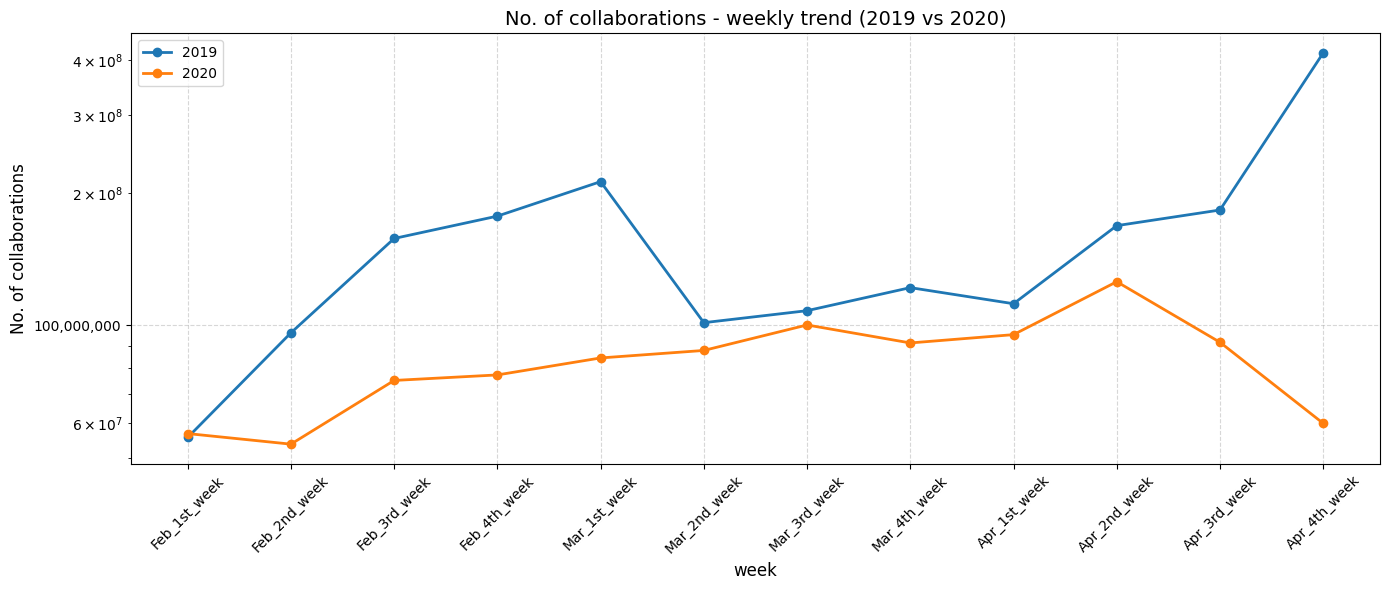

In [103]:
# plotting for collaborations over time
metrics_plot(network_metrics, 'num_edges', 'No. of collaborations', use_log = True)

- The number of edges represents number of collaborations in the network, from the plot the number of collaborations was consistently higher in 2019 than in 2020 which shows a similar trend to density and average degree. This indicated a denser more interconnected collaboration structure among developers in 2019.
- In 2019, I can see a steady rise in collaboration volume from about 56 million edges in early Febuary to a peak of over 210 million edges by early March. Then there was drop trend similar to density and average degree and then a rise to peak by end of April with around 258 million edges.
- In contrast, the 2020 trend appears to be smoother in comparision to 2019, starting with over 55 million edges and moslty fluctuating between 100 million edges with a peak of 127 million mid April, then shows a decline trend to a least of around 60 million edges by end of April. This suggests more moderate and fragmented collaboration pattern, despite having more active developers.
- Overall, this trend aligns closely with what we observed in network density and average degree, which reinforces the pattern of collaborations we see here. Even though 2020 has a higher number of unique developers acitve each week, the volume of collaborations is greater in 2019, suggesting that developers were engaging in more large scale, interconnected efforts.

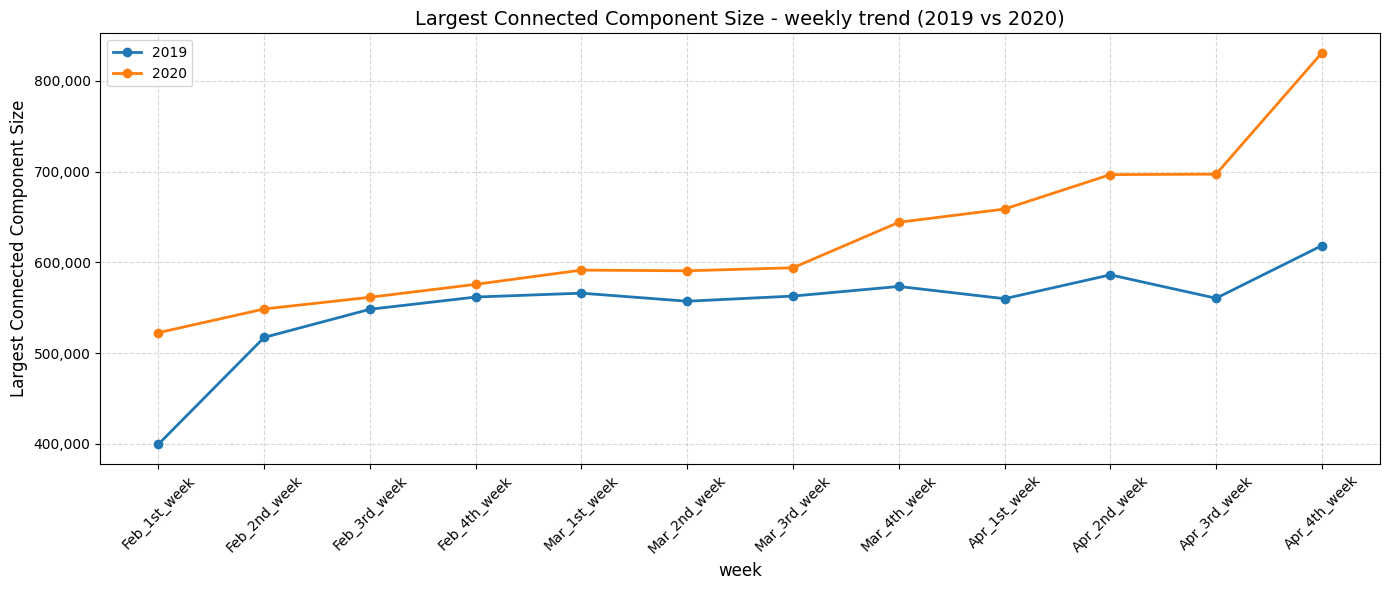

In [104]:
# plotting largest no. of developers in the biggest connected clusters
metrics_plot(network_metrics, 'largest_component_size', 'Largest Connected Component Size')

- The largest connected component size shows the number of developers who were part of the biggest cluster in the collaboration network, essentially reflecting the most cohesive collaborative cluster each week. I can see 2020 had a larger component connected size than 2019 throughout the observed weeks, which shows that a higher portion of developers were working in a common collaborative environment.
- In both years, the lcc consistently grew from early Febuary to April. In 2019, the component started at around 400K in early Febuary, rising steadily to about 618K by the end of April. It was moslty stable with a little fluctuation.
- In 2020, the trend was similar, starting from 522K from early Febuary and climbing steadily to nearly 831K by end of April. While both the years showed growth and was steady, the component from 2019 remained smaller throughout compared to 2020, suggesting more fragmented or parallel collaborations.
- Overall, 2020 shows stronger rise, especially from mid March to April, where the component grew from around 590K to 830K, possibly reflecting a temporary centralization or increased focus among developers.

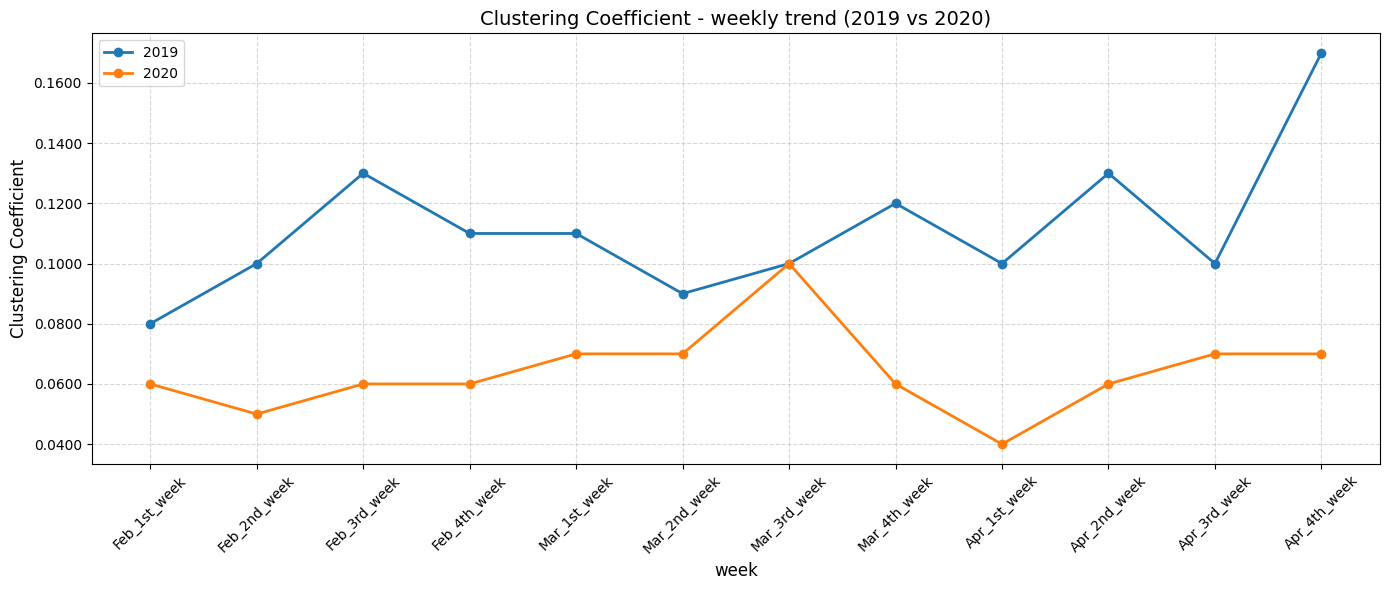

In [99]:
# plotting clustering coefficient trend
metrics_plot(network_metrics, 'clustering_coefficient', 'Clustering Coefficient')

- The clustering coefficient represents how likely it is that developer who collaborate with the same developer also collaborate with each other, essentially showing the tightness or triangle like patterns in network. A higher value suggests more tightly knit collaboration group.
- In 2019, clustering coefficients fluctuated between 0.08 and 0.17, indicating moderately cohesive collaboration groups with some week to week variations and noticeable peaks. In 2020, clustering remains consistently lower, staying between 0.04 and 0.07 for most weeks. A brief rise to 0.10 occurs in mid March, but it quickly dips again.
- 2020 had more developers but a lower density and average degree, meaning people were less interconnected overall, which aligns with the lower clustering coefficient.
- In 2019, developers were in a tight knit clusters and also are collaborating more, in contrast with 2020, despite of larger LCC, developers were not forming tight knit groups and collaborating less, likely due to pandemic and remote work.


***Overall Pre vs Post COVID Trend Summary***  

| **Trend**                 | **Metric**              | **2019 (Pre-COVID)**         | **2020 (Post-COVID)**              | **Interpretation**                             |
|---------------------------|--------------------------|-------------------------------|-------------------------------------|------------------------------------------------|
| Active Developers | num_nodes | 480K - 716K | 618K - 1M+ | More developers were active during COVID especially in April 2020. |
| Collaborations (Edges) | num_edges | 55M - 415M | 53M - 125M | Fewer developer interactions occured post COVID, despite more active users. |
| Developer Network Density | density | 0.00048 - 0.0016 | 0.00026 - 0.00042 | developer interconnections were higher in 2019 compared to 2020 despite of more developers working in 2020. |
| Average Degree | average_degree | 231.9 - 1160.0 | 166.9 - 311.8 | Developers collaborated with more peers in 2019 than in 2020. |
| Network fragmentation | number_of_components | 27K - 35K | 32K - 60K | The developer network was more fragmented post COVID. |
| Large community size | largest_component_size | 399K - 618K | 522K - 831K | Core communities remained strong and even grew during COVID. |
| Local Collaboration Clustering | Clustering coefficient | 0.08 - 0.17 | 0.04 - 0.10 | developer clusters were smaller during COVID phase, so local collaborations weekend post COVID |



**When comparing developer collaboration on GitHub before and after COVID, several clear trends emerge from the data, From Febuary to April 2020, the number of active developers increased significantly, reaching over 1 million in the last week of April, compared to a peak of around 716,000 in 2019. However, despite this increase in participants, collaboration intensity declined.**  
**In 2019, developers were more tightly connected, the average degree peaked at 1160, and network density reached up to 0.0016, indicating strong interconnections and group activity. In contrast, 2020 saw average degrees mostly between 166 and 311, and density dropped as low as 0.00026, showing that developers were more dispersed and collaborated less closely. **  
**The number of components also increased post COVID, rising from a typical 27K - 35K range in 2019 to as high as 60K in 2020, which means more isolated groups were forming. But at the same time, the largest communities stayed strong, with some even growing bigger from 618K in 2019 to 831K in 2020. So while the overall network became more fragmented, big active groups still held together.**  
**Finally, the clustering coefficient, which reflects how often developers formed tight triads, dropped from 0.17 in 2019 to around 0.04 - 0.10 in 2020, reinforcing the idea that collaboration structures weekened during the pandemic.**  
**Overall, while COVID led to a surge in developer participation, collaboration became more fragmented and distributed, with fewer connections per developer and less cohesive community structures.**

In [110]:
gc.collect()

488622

A sample network graph plot, where I took a 100 nodes sample of the subgraph with largest connected components.

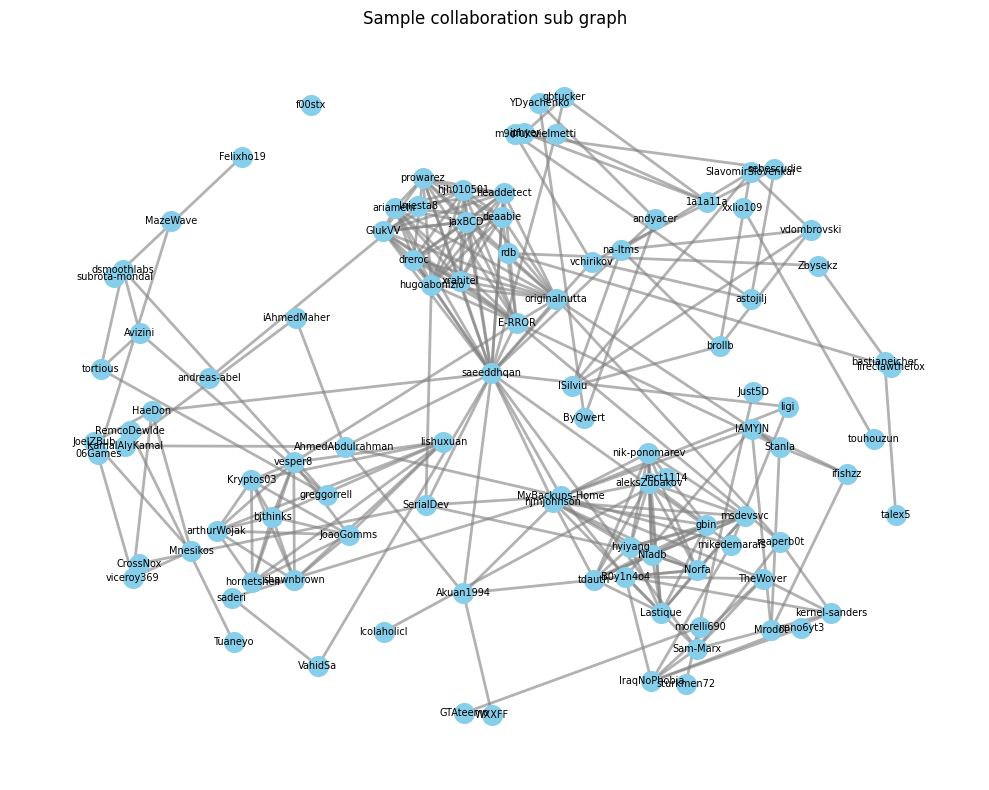

In [120]:
# opening a graph
with open('/content/graphs/2019/week_2019-02-04.gpickle', 'rb') as f:
    G = pickle.load(f)

# getting the largest connected component of the graph
largest_cc = max(nx.connected_components(G), key = len)
# making a sub graph from the largest connected component
G_lcc = G.subgraph(largest_cc)

del G, largest_cc

# getting a list of 100 nodes
sample_nodes = list(G_lcc.nodes())[:100]
# making a grapg of those 100 nodes
subgraph = G_lcc.subgraph(sample_nodes)

del G_lcc
gc.collect()

pos = nx.spring_layout(subgraph, seed = 42, k = 0.7)
# pos = nx.kamada_kawai_layout(subgraph)


plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(subgraph, pos, node_color='skyblue', node_size=200)
nx.draw_networkx_edges(subgraph, pos, edge_color='gray', width=2, alpha=0.6)
nx.draw_networkx_labels(subgraph, pos, font_size=7)

plt.title("Sample collaboration sub graph")
plt.axis('off')
plt.tight_layout()
plt.show()

A sample network graph where I used BFS tree to get plot 100 nodes which are all connected to each other with max depth of 2 nodes from a subgraph of largest connected components. This way we can make sure that all nodes are related to other and connected.

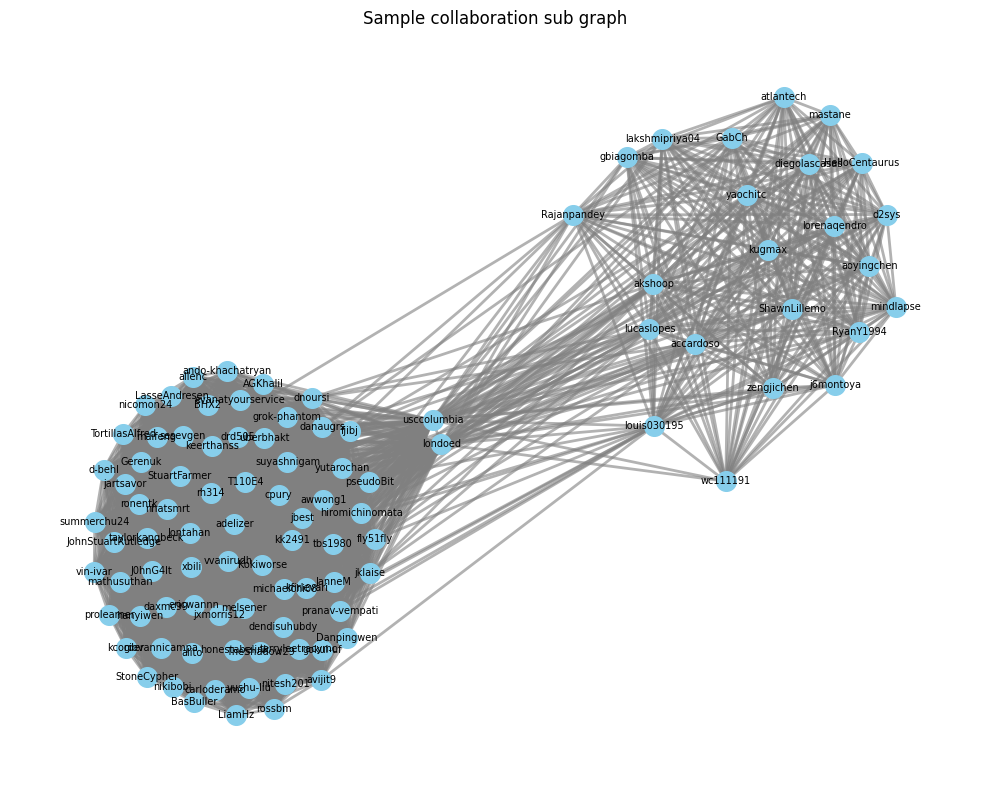

In [122]:
# opening a graph
with open('/content/graphs/2019/week_2019-02-04.gpickle', 'rb') as f:
    G = pickle.load(f)

# getting the largest connected component of the graph
largest_cc = max(nx.connected_components(G), key = len)
# making a sub graph from the largest connected component
G_lcc = G.subgraph(largest_cc)

del G, largest_cc

# setting a start node randomly
start_node = random.choice(list(G_lcc.nodes()))
# using BFS tree to get 100 nodes from the start node with depth 2
sample_nodes = list(nx.bfs_tree(G_lcc, source=start_node, depth_limit=2).nodes)[:100]
# maing a subgraph from the sampled nodes
subgraph = G_lcc.subgraph(sample_nodes)

del G_lcc
gc.collect()

# using spring layout
pos = nx.spring_layout(subgraph, seed = 42, k = 0.7)
# pos = nx.kamada_kawai_layout(subgraph)


plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(subgraph, pos, node_color='skyblue', node_size=200)
nx.draw_networkx_edges(subgraph, pos, edge_color='gray', width=2, alpha=0.6)
nx.draw_networkx_labels(subgraph, pos, font_size=7)

plt.title("Sample collaboration sub graph")
plt.axis('off')
plt.tight_layout()
plt.show()